<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/coiled_pytorch_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# dask + coiled + pytorch + colab (oh my!)

This is based on 
https://examples.dask.org/machine-learning/torch-prediction.html
but modified so that the dask client uses a cluster setup using coiled.io, as explained here
https://docs.coiled.io/user_guide/getting_started.html



## Install coiled

In [1]:
!pip install coiled


     |████████████████████████████████| 61kB 5.8MB/s 
     |████████████████████████████████| 204kB 16.1MB/s 
     |████████████████████████████████| 675kB 23.8MB/s 
     |████████████████████████████████| 901kB 32.8MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 133kB 51.8MB/s 
     |████████████████████████████████| 1.3MB 23.3MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 112kB 61.2MB/s 
     |████████████████████████████████| 7.2MB 34.9MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
     |████████████████████████████████| 143kB 59.5MB/s 
     |████████████████████████████████| 296kB 64.7MB/s 
     |████████████████████████████████| 143kB 61.2MB/s 
  Created wheel for aiobotocore: filename=aiobotocore-1.2.1-cp37-none-any.whl size=45690 sha256=1ec7a1071db45dd09dbb889b2bbf5e83ff5625c5101756fc53b4605c2933c3af
  Stored in directory: /root/.cache/pip/wheels/68/00/41/996683a

In [2]:
!coiled login


Please login to https://cloud.coiled.io/profile to get your token
Token: 
Authentication successful
Credentials have been saved at /root/.config/dask/coiled.yaml


In [3]:
import coiled

#  https://cloud.coiled.io/examples/software/hyperband-optimization
cluster = coiled.Cluster(
    n_workers=2, #10 # use 2 to make startup time faster
    software="examples/hyperband-optimization", # we pick this envrionment since it contains pytorch
)


import dask.distributed
client = dask.distributed.Client(cluster)

Creating Cluster. This takes about a minute ...Checking environment images
Valid environment image found


/usr/local/lib/python3.7/dist-packages/distributed/client.py:1135: VersionMismatchWarning: Mismatched versions found

+---------+----------------+---------------+---------------+
| Package | client         | scheduler     | workers       |
+---------+----------------+---------------+---------------+
| numpy   | 1.19.5         | 1.20.1        | 1.20.1        |
| python  | 3.7.10.final.0 | 3.8.6.final.0 | 3.8.6.final.0 |
| tornado | 5.1.1          | 6.1           | 6.1           |
+---------+----------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


## Clone pyProbml

We need access to https://github.com/probml/pyprobml/blob/master/scripts/tutorial_helper.py which is a copy of https://github.com/dask/dask-examples/blob/main/machine-learning/tutorial_helper.py

In [6]:

!git clone https://github.com/probml/pyprobml 
%cd pyprobml/scripts

Cloning into 'pyprobml'...
remote: Enumerating objects: 6938, done.
remote: Total 6938 (delta 0), reused 0 (delta 0), pack-reused 6938
Receiving objects: 100% (6938/6938), 341.58 MiB | 29.55 MiB/s, done.
Resolving deltas: 100% (3647/3647), done.
Checking out files: 100% (753/753), done.
/content/pyprobml/scripts


## Download data

In [10]:
# from 
# https://examples.dask.org/machine-learning/torch-prediction.html

import urllib.request
import zipfile

filename, _ = urllib.request.urlretrieve("https://download.pytorch.org/tutorial/hymenoptera_data.zip", "data.zip")
zipfile.ZipFile(filename).extractall()
  

In [11]:
!pwd

/content/pyprobml/scripts


In [14]:
!ls h*

hbayes_bernoulli_bap_pymc3.py	   healthy_levels_plot.py
hbayes_bernoulli_covid_pymc3.py    height_weight_whiten_plot.py
hbayes_binom_covid_pymc3.py	   hinge_loss_plot.py
hbayes_binom_covid_uninf_pymc3.py  hinton_diagram.py
hbayes_binom_rats_pymc3.py	   huber_loss_plot.py

healthy-levels:
README.md  rectangle_estimation  setup.py

hymenoptera_data:
train  val


## Pytorch model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Epoch 0/1
----------
train Loss: 0.5970 Acc: 0.6516
val Loss: 0.1900 Acc: 0.9542

Epoch 1/1
----------
train Loss: 0.6929 Acc: 0.7090
val Loss: 0.1844 Acc: 0.9281

Training complete in 0m 4s
Best val Acc: 0.954248


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f99d57780d0>,
      dtype=object)

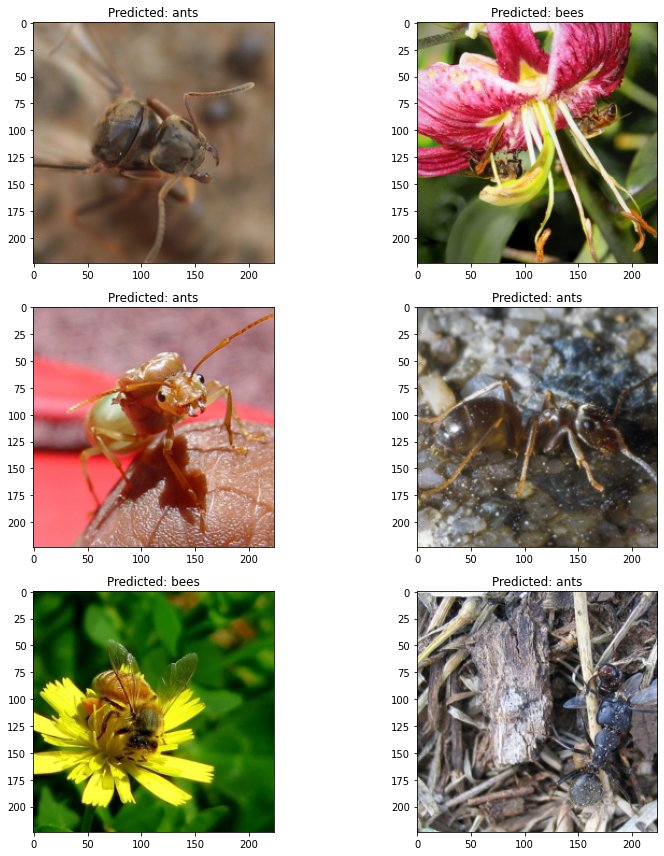

In [15]:
import torchvision
from tutorial_helper import (imshow, train_model, visualize_model,
                             dataloaders, class_names, finetune_model)

import dask

model = finetune_model()

visualize_model(model)

## Load data on workers

In [18]:
# Loading the data on the workers


import glob
import toolz
import dask
import dask.array as da
import torch
from torchvision import transforms
from PIL import Image


@dask.delayed
def load(path, fs=__builtins__):
    with fs.open(path, 'rb') as f:
        img = Image.open(f).convert("RGB")
        return img


@dask.delayed
def transform(img):
    trn = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return trn(img)

objs = [load(x) for x in glob.glob("hymenoptera_data/val/*/*.jpg")]

tensors = [transform(x) for x in objs]

batches = [dask.delayed(torch.stack)(batch)
           for batch in toolz.partition_all(10, tensors)]

print(batches[:5])



[Delayed('stack-c43ea4df-451d-4543-b3a2-0d17f5abb900'), Delayed('stack-b579df07-2fc5-4647-bbe1-1f7488877143'), Delayed('stack-8b211b51-8078-4c42-b1d5-ec10ef682177'), Delayed('stack-16ead968-e462-4f5e-a500-554f20c21d45'), Delayed('stack-23989902-dd32-488f-b73b-5d76c620756c')]


## Move model onto worker

In [17]:


import pickle

print(dask.utils.format_bytes(len(pickle.dumps(model))))


dmodel = dask.delayed(model.cpu()) # ensuring model is on the CPU

44.80 MB


## Lazy predictions

In [19]:

@dask.delayed
def predict(batch, model):
    with torch.no_grad():
        out = model(batch)
        _, predicted = torch.max(out, 1)
        predicted = predicted.numpy()
    return predicted

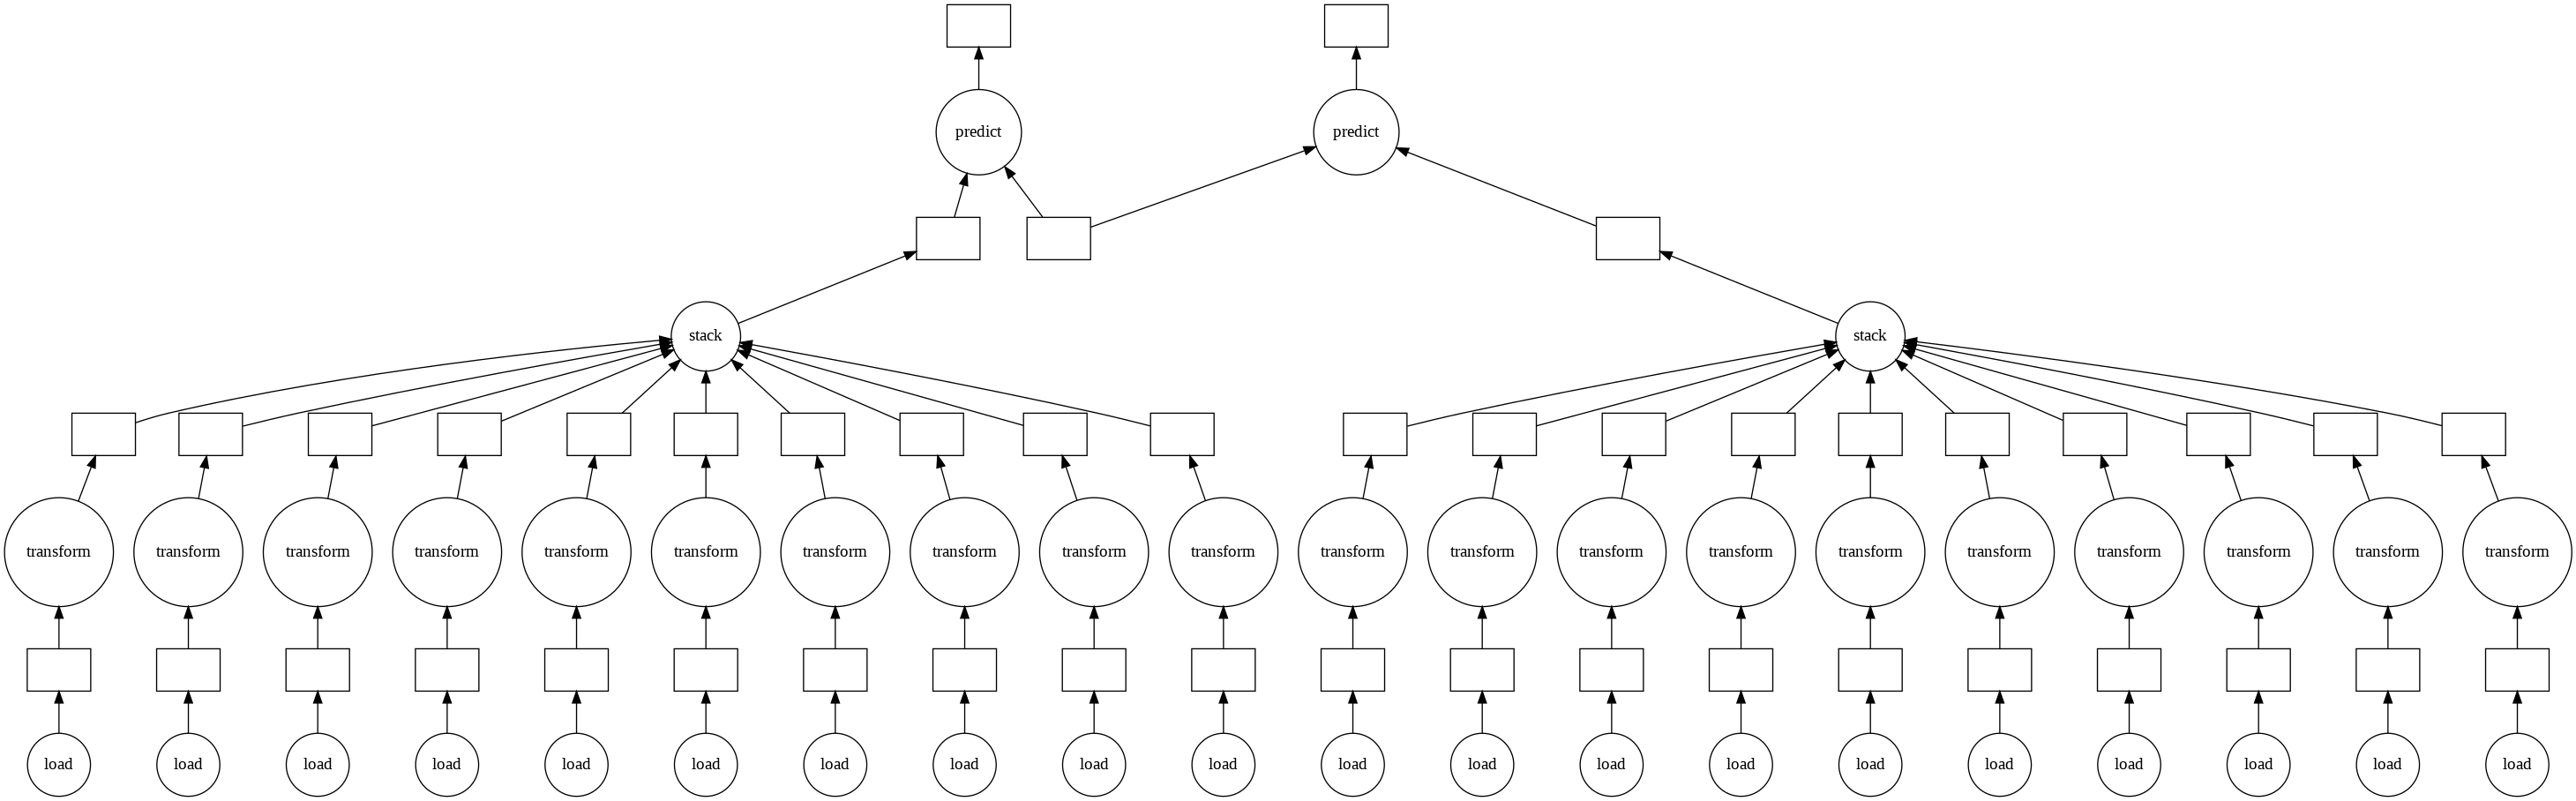

In [20]:
predictions = [predict(batch, dmodel) for batch in batches]
dask.visualize(predictions[:2])

## Execute!

In [ ]:
predictions = dask.compute(*predictions)
predictions

distributed.protocol.pickle - INFO - Failed to deserialize b"\x80\x05\x95O\x03\x00\x00\x00\x00\x00\x00\x8c\x16tblib.pickling_support\x94\x8c\x12unpickle_exception\x94\x93\x94(\x8c\x08builtins\x94\x8c\tTypeError\x94\x93\x94\x8c'an integer is required (got type bytes)\x94\x85\x94Nh\x00\x8c\x12unpickle_traceback\x94\x93\x94\x8c\x05tblib\x94\x8c\x05Frame\x94\x93\x94)\x81\x94}\x94(\x8c\tf_globals\x94}\x94(\x8c\x08__name__\x94\x8c\x12distributed.worker\x94\x8c\x08__file__\x94\x8cH/opt/conda/envs/coiled/lib/python3.8/site-packages/distributed/worker.py\x94u\x8c\x06f_code\x94h\n\x8c\x04Code\x94\x93\x94)\x81\x94}\x94(\x8c\x0bco_filename\x94h\x14\x8c\x07co_name\x94\x8c\x10ensure_computing\x94ububM\xfe\th\n\x8c\tTraceback\x94\x93\x94)\x81\x94}\x94(\x8c\x08tb_frame\x94h\x0c)\x81\x94}\x94(h\x0f}\x94(h\x11h\x12h\x13h\x14uh\x15h\x17)\x81\x94}\x94(h\x1ah\x14h\x1b\x8c\x17_maybe_deserialize_task\x94ubub\x8c\ttb_lineno\x94M\xcc\t\x8c\x07tb_next\x94h\x1e)\x81\x94}\x94(h!h\x0c)\x81\x94}\x94(h\x0f}\x94(h\x1